<a href="https://colab.research.google.com/github/koyomin9zx/CS313.K21-Homework/blob/master/lazada_review_comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Preprocessing***

**upload and extract dataset**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ln -s /content/drive/'My Drive'/Lazada_review

In [0]:
!pip install scikit-learn==0.23.1
!pip install underthesea

In [0]:
!pip install unidecode

**import lib**

In [0]:
import pandas as pd
import glob
import seaborn as sns
import string
from string import digits, punctuation
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from underthesea import word_tokenize
import unidecode
import joblib
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


**Import data into Pandas**

In [7]:
df_train= pd.read_csv('/content/Lazada_review/train.csv')
df_test= pd.read_csv('/content/Lazada_review/test.csv')

df_train.head(5)


,cau_goc,nhan
0,"cam ơn shop nhiều lam, e nhận dc máy rồi, sài...",1
1,Ngon như ăn cà,1
2,"Ve ngoai hinh khoang 96℅,mat kinh truoc va sau...",1
3,"lỗi vào 4G, phải khởi động lại máy thì mới chu...",0
4,"Đã mua và nhận xét : ngoại hình khá, màn hình ...",0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cau_goc  10000 non-null  object
 1   nhan     10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cau_goc  2537 non-null   object
 1   nhan     2537 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.8+ KB


**DATA VISUALIZATION**

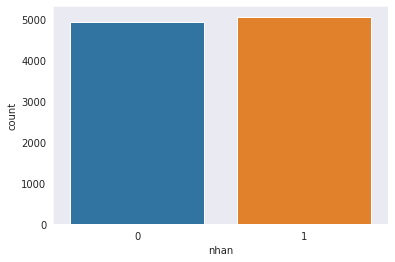

In [10]:
sns.set_style("dark")
sns.countplot(df_train.nhan)

**See how comment look like**

In [11]:
for i,content in enumerate (df_train['cau_goc'], 1):
    if i > 20:
        break
    else:
        print(i, content)



1 cam ơn shop nhiều lam, e nhận dc máy rồi,  sài ok lam, 😄😄😄😄
2 Ngon như ăn cà
3 Ve ngoai hinh khoang 96℅,mat kinh truoc va sau may co vet xuoc.loa e nay hoi be,xet ve gia tien oke.mih dung chi nghe goi,quan trong ben la oke.
4 lỗi vào 4G, phải khởi động lại máy thì mới chuyển E thành 4G, chuyển địa điểm khác bật 4G lên hiện E thì khởi động lại tiếp thì ok
5 Đã mua và nhận xét : ngoại hình khá, màn hình rất rỗ, ý kiến cá nhân mình thì nên bỏ cam trước và tăng độ phân giải màn hình lên tí nữa vì cam trước độ phân giải quá thấp nên chẳng mấy ai chụp hình với nó cả 
6 Máy bị lỗi giải quyết như thế nào shop oi.
7 Máy lướt web mau nóng máy,mặt lưng bám vân tay khá nhiều,cầm trơn trượt rất dễ rơi.pin mau hết..hơi thất vọng 
8 Sai lầm khi mua máy này. Sản phẩm bị lỗi quá nhiều. Đơ liên tục.ra tgdd họ k đổi cho mình đập luôn máy tại cửa hàng vì sản phẩm lừa khách hàng.k phát trực tiếp trên face.pjn 5k mà k bằng pin 2k.sắc mặt 5 tiếng .dùng chưa đến 2 tương hết pin
9 Máy xài rất ok Với giá tiền

**Text cleansing**

In [12]:
def standardize_data(row):
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    row = re.sub(r"[\.,\?]+$-", "", row)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
    row = row.strip()
    return row

hl_cleansed=[]
for hl in df_train['cau_goc']:
    hl=standardize_data(hl)
    hl_cleansed.append(hl)
    
# View comparison
index=0
print('Original texts :')
print(df_train['cau_goc'][index])
print('\nAfter cleansed :')
print(hl_cleansed[index])

Original texts :
cam ơn shop nhiều lam, e nhận dc máy rồi,  sài ok lam, 😄😄😄😄

After cleansed :
cam ơn shop nhiều lam  e nhận dc máy rồi   sài ok lam  😄😄😄😄


**Tokenization, remove accents, remove stopwords**

In [71]:
def vi_tokenizer(row):
    return word_tokenize(row, format="text")

def remove_accents(row):
  return unidecode.unidecode(row)

def remove_stopwords(stopwords,hl_split):
  sent = [s for s in hl_split if s not in stopwords ]
  return sent

stopwords=set(open('/content/Lazada_review/stopwords.txt').read().split(' ')[:-1])

hl_tokens = []
for hl in hl_cleansed:
    hl=vi_tokenizer(hl)
    clean=remove_stopwords(stopwords,hl.split())
    clean=[remove_accents(s) for s in clean]
    hl_tokens.append(clean)

# View Comparison
index=3
print('Before tokenization :')
print(hl_cleansed[index])
print('\nAfter tokenization :')
print(hl_tokens[index])

Before tokenization :
lỗi vào 4G  phải khởi động lại máy thì mới chuyển E thành 4G  chuyển địa điểm khác bật 4G lên hiện E thì khởi động lại tiếp thì ok

After tokenization :
['loi', '4G', 'khoi_dong', 'may', 'moi', 'chuyen', 'E', 'thanh', '4G', 'chuyen', 'dia_diem', 'khac', 'bat', '4G', 'hien', 'E', 'khoi_dong', 'tiep', 'ok']


**Lemmatization**

# ***Training LSTM Model***

In [0]:
# Vectorize and convert text into sequences
max_features = 2000
max_token = len(max(hl_tokens,key=len))
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(hl_tokens)
sequences = tokenizer.texts_to_sequences(hl_tokens)
X_Train = pad_sequences(sequences, maxlen=max_token)

Split Train, Test

In [0]:
hl_test=[]
for hl in df_test['cau_goc']:
    hl=standardize_data(hl)
    hl_test.append(hl)

hl_tokens_test = []
for hl in hl_test:
    hl=vi_tokenizer(hl)
    clean=remove_stopwords(stopwords,hl.split())
    clean=[remove_accents(s) for s in clean]
    hl_tokens_test.append(clean)

sequences_test = tokenizer.texts_to_sequences(hl_tokens_test)
X_test=pad_sequences(sequences_test, maxlen=max_token)


In [0]:
Y_Train=df_train['nhan'].values
Y_Train = np.vstack(Y_Train)

Y_test=df_test['nhan'].values
Y_test=np.vstack(Y_test)

Building the Model

In [85]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = max_token))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 64)           128000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12416     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                

Training process

In [0]:
epoch = 20
batch_size = 128
history=model.fit(X_Train, Y_Train, epochs = epoch, batch_size=batch_size, verbose = 2, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/20
 - 34s - loss: 49770890527.3704 - accuracy: 0.6094 - val_loss: 0.6931 - val_accuracy: 0.5090
Epoch 2/20
 - 33s - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6930 - val_accuracy: 0.5090
Epoch 3/20


# ***Model Evaluation***



IndexError: ignored

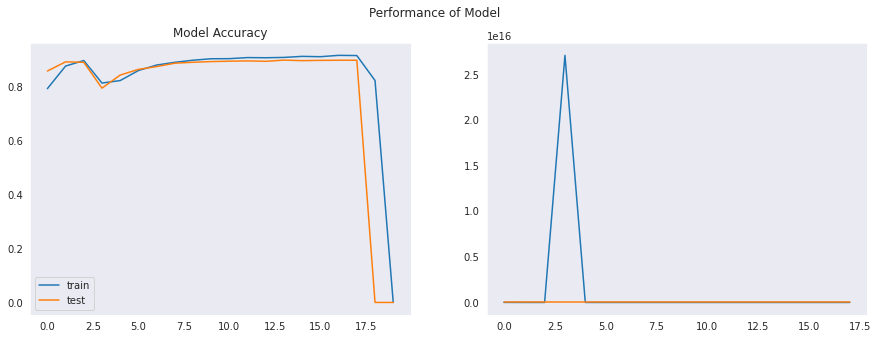

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

# ***Test Model***

In [0]:
pred=np.around(model.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,pred))
plt.show()

In [0]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       279
           1       0.96      0.78      0.86       308

    accuracy                           0.87       587
   macro avg       0.88      0.87      0.87       587
weighted avg       0.88      0.87      0.87       587



# ***Use Another ML Algorithms to Classify***

**Preparing the Data**

In [0]:
X = [" ".join(x) for x in hl_lemmatized]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X,df['CLASS'],test_size=0.3)

**Word Vectorization using TF-IDF**

In [0]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [0]:
print(Tfidf_vect.vocabulary_)

{'best': 295, 'part': 2375, 'wierd': 3556, 'but': 413, 'funny': 1174, 'hey': 1375, 'guy': 1301, 'im': 1642, 'human': 1601, 'dont': 816, 'want': 3471, 'to': 3260, 'be': 260, 'sexy': 2837, 'fuck': 1163, 'giraffe': 1218, 'already': 103, 'have': 1344, 'the': 3206, 'money': 2146, 'for': 1117, 'surgery': 3126, 'elongate': 897, 'my': 2202, 'spinal': 3006, 'core': 625, 'change': 469, 'skin': 2914, 'pigment': 2434, 'and': 131, 'everything': 967, 'else': 898, 'like': 1900, 'this': 3230, 'post': 2497, 'so': 2945, 'others': 2346, 'can': 426, 'root': 2751, 'me': 2051, 'on': 2321, 'in': 1656, 'dream': 830, 'with': 3575, 'you': 3652, 'make': 2020, 'music': 2189, 'check': 488, 'out': 2352, 'first': 1090, 'song': 2964, 'giraffebruuh': 1219, 'party': 2376, 'rocklolwho': 2745, 'shuffle': 2879, 'rock': 2743, 'omg': 2318, 'just': 1781, 'really': 2645, 'fun': 1171, 'awsome': 226, 'wow': 3604, 'increible': 1667, 'love': 1971, 'much': 2181, 'likeee': 1905, 'miss': 2122, 'when': 3537, 'people': 2404, 'dress': 

## **Trainning on the SVM classifier**

In [0]:
SVM = svm.SVC(C=1.0, kernel='linear', verbose=True)
SVM.fit(Train_X_Tfidf,Train_Y)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

**Predict and evaluate the SVM classifier**

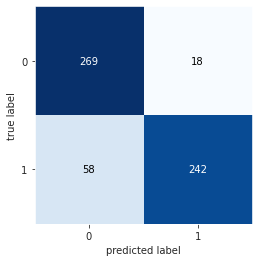

In [0]:
predictions_SVM=SVM.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_SVM))
plt.show()

In [0]:
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       287
           1       0.93      0.81      0.86       300

    accuracy                           0.87       587
   macro avg       0.88      0.87      0.87       587
weighted avg       0.88      0.87      0.87       587



## **Trainning on the Naive Bayes Classifier**

In [0]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Predict and evaluate the Naive Bayes Classifier**

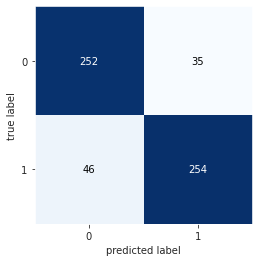

In [0]:
predictions_NB=Naive.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_NB))
plt.show()

In [0]:
print(classification_report(Test_Y,predictions_NB))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       287
           1       0.88      0.85      0.86       300

    accuracy                           0.86       587
   macro avg       0.86      0.86      0.86       587
weighted avg       0.86      0.86      0.86       587



# ***Save model***

In [0]:
joblib.dump(Tfidf_vect, '/content/model/tfidf.pkl')
joblib.dump(tokenizer, '/content/model/tokenizer_LSTM.pkl')
joblib.dump(model, '/content/model/LSTM_model.pkl')
joblib.dump(SVM, '/content/model/SVM_model.pkl')
joblib.dump(Naive, '/content/model/NB_model.pkl')

['/content/model/NB_model.pkl']

# ***Enter comment and check***

## *utils*

In [0]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re
import string
from string import digits, punctuation

def word_lenmatizer(text):
    cleanr = re.compile('<.*?>')
    text=re.sub(cleanr, ' ', text)
    clean = text.translate(str.maketrans('', '', punctuation))
    clean = clean.translate(str.maketrans('', '', digits))
    text_tokenizer=clean.split()
    # Init Lemmatizer
    lemmatizer = WordNetLemmatizer()
    hl_lemmatized = []
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_tokenizer]
    hl_lemmatized.append(lemm)
    return hl_lemmatized

def LSTM_predict(text,model,tokenizer):
  w_lenmatizer=word_lenmatizer(text)
  max_token = 14
  sequences = tokenizer.texts_to_sequences(w_lenmatizer)
  X = pad_sequences(sequences, maxlen=max_token)
  if np.around(model.predict(X)[0])==1:
    print(text)
    print("=============> SPAM\n")
  else:
    print(text)
    print("=============> HAM\n")

def predict(text,model,tfidf_vector):
  w_lenmatizer=word_lenmatizer(text)
  w_lenmatizer = [" ".join(x) for x in w_lenmatizer]
  X_Tfidf = tfidf_vector.transform(w_lenmatizer)
  if model.predict(X_Tfidf)[0]==1:
    print(text)
    print("=============> SPAM\n")
  else:
    print(text)
    print("=============> HAM\n")



## Predict

Load model 

In [0]:
model_LSTM=joblib.load('/content/model/LSTM_model.pkl')
tokenizer_LSTM=joblib.load('/content/model/tokenizer_LSTM.pkl')
SVM_model=joblib.load('/content/model/SVM_model.pkl')
NB_model=joblib.load('/content/model/NB_model.pkl')
tfidf_vec=joblib.load('/content/model/tfidf.pkl')


Using LSTM model to predict

In [0]:
cmt='Please subcribe my channel'
LSTM_predict(cmt,model_LSTM,tokenizer_LSTM)


cmt2='I just remembered the song because of Alvin and The Chipmunks 😂'
LSTM_predict(cmt2,model_LSTM,tokenizer_LSTM)

Please subcribe my channel
=============> SPAM

I just remembered the song because of Alvin and The Chipmunks 😂
=============> HAM



Using SVM clasifier

In [0]:
cmt='Follow me on instagram, remember to like and subcribe'
predict(cmt,SVM_model,tfidf_vec)


cmt2='This is probably the best song that represents the world cup ever.'
predict(cmt2,SVM_model,tfidf_vec)

Take a look at this video on YouTube
=============> SPAM

Such a shame that this song didnt reach 1B in 10 years.
=============> HAM



Using NB clasifier


In [0]:
cmt='Such a shame that this song didnt reach 1B in 10 years.'
predict(cmt,NB_model,tfidf_vec)


cmt2='LIKE THIS COMMENT IF YOU ARE WATCHING.'
predict(cmt2,NB_model,tfidf_vec)

Such a shame that this song didnt reach 1B in 10 years.
=============> HAM

LIKE THIS COMMENT IF YOU ARE WATCHING.
=============> SPAM

